In [1]:
# Downloading libraries
!pip install --upgrade xgboost
!pip install --upgrade python
!pip install --upgrade google.cloud
!pip install --upgrade pandas
!pip install --upgrade pandas_ml

Requirement already up-to-date: xgboost in /usr/local/lib/python2.7/dist-packages
Requirement already up-to-date: numpy in /usr/local/lib/python2.7/dist-packages (from xgboost)
Requirement already up-to-date: scipy in /usr/local/lib/python2.7/dist-packages (from xgboost)
Requirement already up-to-date: python in /usr/lib/python2.7/lib-dynload
  Using cached google_cloud-0.32.0-py2.py3-none-any.whl
Requirement already up-to-date: google-cloud-logging<1.5dev,>=1.4.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-error-reporting<0.29dev,>=0.28.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-pubsub<0.31dev,>=0.30.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-vision<0.30dev,>=0.29.0 in /usr/local/lib/python2.7/dist-packages (from google.cloud)
Requirement already up-to-date: google-cloud-core<0.29dev,>=0.28.0 

In [2]:
# importing libraries
import google.cloud
import google.datalab.bigquery as bq
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn import cross_validation, metrics   #Additional scklearn functions
from sklearn.grid_search import GridSearchCV   #Perforing grid search

from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [3]:
# Importing ADS from Big Query
query = """
SELECT *
FROM
`dcw-data-platform-analysis.EDA.ADS_TXN_CS_SAMPLE_165K`
"""

    
df = bq.Query(query).execute().result().to_dataframe()

df.head()

,SCV_INDIVIDUAL_KEY,quarter_start,Y_PREMIUM_ANDROID,PURCHASED_1QTR,PURCHASED_2QTR,PURCHASED_3QTR,PURCHASED_4QTR,PURCHASED_5QTR,PURCHASED_6QTR,PURCHASED_7QTR,...,o_Views_Prem_android_hs_flag,o_Views_Prem_non_android_hs_flag,o_Views_non_Prem_hs_flag,o_Views_Prem_hs_post_pay,o_Views_Prem_hs_pre_pay,o_Views_Prem_hs_other,o_Views_Prem_post_pay_flag,o_Views_Prem_pre_pay_flag,o_Views_Prem_hs_other_flag,o_Cumulative_Active_Weeks
0,2155386730,2017-01-01,0,0,0,0,1,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2146816305,2017-07-01,0,1,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,2367180744,2017-04-01,0,0,1,0,0,0,1,1,...,0,1,0,4,0,6,1,0,1,1
3,1627933961,2017-04-01,0,1,1,0,0,1,0,0,...,0,1,0,0,0,22,0,0,1,2
4,5004504900,2017-07-01,1,1,0,1,0,0,0,1,...,0,1,0,0,0,53,0,0,1,1


In [4]:
# dropping columns based on business context
df.drop(['CUSTOMER_TYPE','TEC_1QTR','TEC_2QTR','TEC_3QTR','TEC_4QTR','TEC_5QTR','TEC_6QTR'],axis=1, inplace=True)

len(df.columns)

618

In [5]:
# dropping columns based on business context
df.drop(['TEC_7QTR','TEC_8QTR','TEC_9QTR','TEC_10QTR','TEC_11QTR','TEC_12QTR'],axis=1, inplace=True)
len(df.columns)

612

In [6]:

# Length of train and test datasets
length_of_table = int(len(df))
train_length = int(round(0.7 * length_of_table))
test_length = int(train_length + 1)

# Creating train dataset with 70% rows
train_dataset = df.iloc[0:train_length,:]

# Creating input metrics
input_metrics_train = train_dataset.iloc[:,3:]

# Deciding success metric
sucess_metric_train = train_dataset.iloc[:,2]

print("Lenght of train dataset:")
len(train_dataset.index)




Lenght of train dataset:


115500

In [7]:
## Creating test dataset
test_dataset = df.iloc[test_length:length_of_table,:]

# Selecting input columns
input_metrics_test = test_dataset.iloc[:,3:]

# Deciding success metric
sucess_metric_test = test_dataset.iloc[:,2]


print("Lenght of test dataset:")
len(test_dataset.index)


Lenght of test dataset:


49499

## Model Implementation

In [9]:
# Running XGBoost model with default parameters
model = XGBClassifier()
Model_Results = model.fit(input_metrics_train, sucess_metric_train)

### Model Parameters before ROC Curve

In [10]:
# printing model parameters
print("The model parameters are as follows:")
print(Model_Results)

The model parameters are as follows:
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)


### ROC Curve from Current Model

In [11]:
# Calculating threshold value to differentiate between 0 and 1 labels
import pandas as pd
import pylab as pl
import numpy as np
from sklearn.metrics import roc_curve, auc

def Find_Optimal_Cutoff(target, predicted):
    """ Find the optimal probability cutoff point for a classification model related to event rate
    Parameters
    ----------
    target : Matrix with dependent or target data, where rows are observations

    predicted : Matrix with predicted data, where rows are observations

    Returns
    -------     
    list type, with optimal cutoff value

    """
    fpr, tpr, threshold = roc_curve(target, predicted)
    i = np.arange(len(tpr)) 
    roc = pd.DataFrame({'tf' : pd.Series(tpr-(1-fpr), index=i), 'threshold' : pd.Series(threshold, index=i)})
    roc_t = roc.iloc[(roc.tf-0).abs().argsort()[:1]]

    return list(roc_t['threshold']) 


# Add prediction probability to dataframe
Y_Pred_ROC = Model_Results.predict(input_metrics_test)
Y_Pred_ROC_prob = Model_Results.predict_proba(input_metrics_test)[:,1]

print("Threshold obtained from current curve:")
# Find optimal probability threshold
threshold = Find_Optimal_Cutoff(sucess_metric_test, Y_Pred_ROC_prob)
print threshold

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Threshold obtained from current curve:
[0.21082773804664612]


## Building Model with Threshold

In [23]:
# fit model 
model = XGBClassifier(base_score=threshold[0],n_estimators=300,learning_rate=0.3)
Model_Results = model.fit(input_metrics_train, sucess_metric_train)

print("The model parameters are as follows:")
print(Model_Results)

The model parameters are as follows:
XGBClassifier(base_score=0.210827738047, booster='gbtree',
       colsample_bylevel=1, colsample_bytree=1, gamma=0, learning_rate=0.3,
       max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
       n_estimators=300, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1)


### Important Metrics

In [24]:
## Creating a dataframe of the features and their importance from the XGBoost model

Model_Features = pd.DataFrame(data=Model_Results.feature_importances_,    # values
              columns = ['Importance'])
Model_Features['Attribute'] = input_metrics_train.columns

## Filtering only important metrics

Important_Metrics = Model_Features[Model_Features['Importance']>0]

from pandas import DataFrame
import pandas as pd
## Displaying large number of rows
pd.options.display.max_rows = 4000
print("The list of important metrics in descending order are: (Most to least important)")

Important_Metric_inorder = Important_Metrics.sort_values('Importance', ascending = False)
Important_Metric_inorder

The list of important metrics in descending order are: (Most to least important)


,Importance,Attribute
264,0.081497,DIFF_CURRENT_PREV_PURCHASE
368,0.078934,AVERAGE_TEC
359,0.045618,LAST_TEC
372,0.031779,PAST_2NDLINE_CONTRACT
370,0.025115,AVERAGE_TARIFF
371,0.024090,PAST_RETAINED_CONTRACT
361,0.021015,LAST_TARIFF
367,0.018452,AVERAGE_DATA
374,0.016914,PAST_POSTPAY_CONTRACTS
454,0.012814,CUSTOMER_MARKETIBILITY_MARKETABLE


In [26]:
# make predictions for test data
y_pred = Model_Results.predict(input_metrics_test)
y_pred_prob = Model_Results.predict_proba(input_metrics_test)[:,1]
predictions = [value for value in y_pred]

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:171: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [27]:
# evaluate predictions
print("The accuracy is as follows:")
accuracy = accuracy_score(sucess_metric_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

The accuracy is as follows:
Accuracy: 90.29%


Confusion matrix, without normalization
[[22762  1159]
 [ 3646 21932]]
Normalized confusion matrix
[[0.95 0.05]
 [0.14 0.86]]


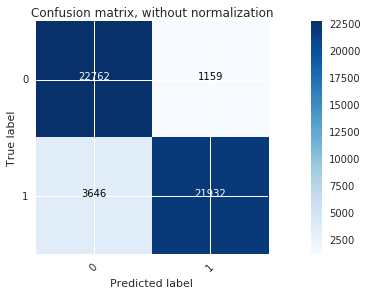

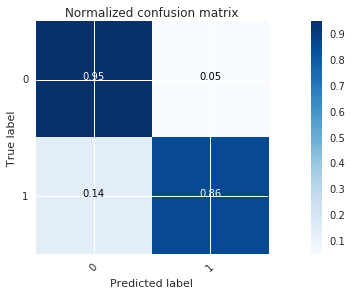

In [28]:
# Printing confusion matrix for model evaluation
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


class_names = np.unique(df.Y_PREMIUM_ANDROID)



def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(sucess_metric_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [29]:
# Deciling customers based on predicted probability
decile = pd.DataFrame(
    {'prob': y_pred_prob,
     'prediction': y_pred,
     'actual': sucess_metric_test
    })
sort_for_decile = decile.sort_values('prob', ascending = False)
sort_for_decile['decile'] = pd.qcut(sort_for_decile['prob'], 10, labels=np.arange(10, 0, -1))
sort_for_decile

,actual,prediction,prob,decile
162843,1,1,1.000000,1
156660,1,1,1.000000,1
134592,1,1,1.000000,1
134605,1,1,0.999999,1
131240,1,1,0.999999,1
134561,1,1,0.999999,1
159742,1,1,0.999999,1
134559,1,1,0.999999,1
133383,1,1,0.999998,1
128457,1,1,0.999998,1


In [30]:
# Calculating actual conversions coverage by decile
decile_group=pd.DataFrame(sort_for_decile.groupby(['decile'])['actual'].sum())
decile_group['decile'] = decile_group.index
decile_group['count']=sort_for_decile.groupby(['decile'])['actual'].count()
decile_group['prediction']=sort_for_decile.groupby(['decile'])['prediction'].sum()
decile_group['per']=(decile_group['actual']/decile_group['actual'].sum())*100
decile_group = decile_group.sort_values(['decile'], ascending=[False ])
decile_group['per_random']=(decile_group['count']/decile_group['count'].sum())*100
decile_group['cum_sum_per_rand'] = decile_group.per_random.cumsum()
decile_group['cum_sum_per'] = decile_group.per.cumsum()
decile_group

,actual,decile,count,prediction,per,per_random,cum_sum_per_rand,cum_sum_per
decile,,,,,,,,
1,4949,1,4950,4950,19.348659,10.000202,10.000202,19.348659
2,4946,2,4950,4950,19.336930,10.000202,20.000404,38.685589
3,4925,3,4950,4950,19.254828,10.000202,30.000606,57.940418
4,4694,4,4950,4950,18.351708,10.000202,40.000808,76.292126
5,3318,5,4949,3291,12.972085,9.998182,49.998990,89.264211
6,1804,6,4950,0,7.052936,10.000202,59.999192,96.317148
7,696,7,4950,0,2.721088,10.000202,69.999394,99.038236
8,201,8,4950,0,0.785832,10.000202,79.999596,99.824068
9,45,9,4950,0,0.175932,10.000202,89.999798,100.000000


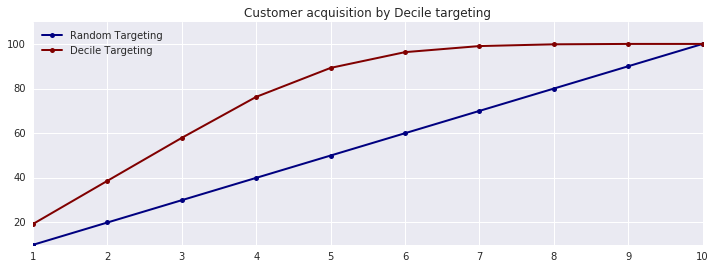

In [31]:
# Plotting conversion coverage by decile
import pandas as pd
values = np.array(decile_group.iloc[:,6:8])
df2 = pd.DataFrame(values, columns=['Random Targeting', 'Decile Targeting'], index=np.array(decile_group.iloc[:,1:2]))
df2.plot(lw=2,colormap='jet',marker='.',markersize=10,title='Customer acquisition by Decile targeting')
#['D1','D2','D3','D4','D5','D6','D7','D8','D9','D10']

In [32]:
# Calculating impact of important features represented by odds
from sklearn.linear_model import LogisticRegression

# Important features list from XGBoost model
cols=Important_Metric_inorder['Attribute']
df_impact=train_dataset[cols]

# success metric
df_impact['Y_PREMIUM_ANDROID']=train_dataset['Y_PREMIUM_ANDROID']
df_impact_na=df_impact.dropna()
input_metrics = df_impact_na[cols]
sucess_metric = df_impact_na['Y_PREMIUM_ANDROID']
logistic = LogisticRegression()
logmodel=logistic.fit(input_metrics,sucess_metric)
coefficients = pd.concat([pd.DataFrame(df_impact_na[cols].columns),pd.DataFrame(np.transpose(logmodel.coef_))], axis = 1)
coefficients.columns=['Attribute','Coef']
coefficients['odds'] = np.exp(coefficients['Coef'])
coefficients.drop(['Coef'],axis=1, inplace=True)
coefficients_sort=coefficients.sort_values('odds', ascending = False)
result = pd.merge( Important_Metric_inorder, coefficients_sort ,how='left', left_on=['Attribute'], right_on = ['Attribute'])
result

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,Importance,Attribute,odds
0,0.081497,DIFF_CURRENT_PREV_PURCHASE,1.000350
1,0.078934,AVERAGE_TEC,1.013984
2,0.045618,LAST_TEC,1.019737
3,0.031779,PAST_2NDLINE_CONTRACT,13.470318
4,0.025115,AVERAGE_TARIFF,0.677465
5,0.024090,PAST_RETAINED_CONTRACT,3.759365
6,0.021015,LAST_TARIFF,0.690744
7,0.018452,AVERAGE_DATA,1.022205
8,0.016914,PAST_POSTPAY_CONTRACTS,0.163592
9,0.012814,CUSTOMER_MARKETIBILITY_MARKETABLE,0.562089


In [33]:
import pickle
# save model to file
pickle.dump(Model_Results, open("proxy_online.pkl", "wb"))